In [63]:
import numpy as np
import pandas as pd
from itertools import product
import tensorflow as tf
from time import time
import multiprocessing
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Lambda, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error, r2_score
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
import os

In [64]:
df = pd.read_csv("Complete_BF_CPP_XY_Data.csv")
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
X = df.iloc[:, 1:27]
Y = df.iloc[:, 27:]
X_scaler = StandardScaler()
X_scaled = X_scaler.fit_transform(X)
Y_scaler = StandardScaler()
Y_scaled = Y_scaler.fit_transform(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_scaled, test_size=0.2, random_state=42)

C:\Users\Omer\AppData\Local\Temp\ipykernel_19956\506610282.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Complete_BF_CPP_XY_Data.csv")


In [65]:
def create_model(layer1_neurons, learning_rate, l2_lambda=0.01, dropout_rate=0.5):
    # Input layer
    input_layer = Input(shape=(26,), name="Input_Layer")
    
    # First network (Network 1) with L2 regularization and dropout
    x = Dense(layer1_neurons[0], activation='relu', kernel_regularizer=l2(l2_lambda), name="Dense_Layer_1")(input_layer)
    x = Dropout(dropout_rate)(x)  # Apply dropout after each dense layer
    
    for i, neurons in enumerate(layer1_neurons[1:], start=2):
        x = Dense(neurons, activation='relu', kernel_regularizer=l2(l2_lambda), name=f"Dense_Layer_{i}")(x)
        x = Dropout(dropout_rate)(x)  # Apply dropout

    # Output layer
    output_1 = Dense(23, activation='linear', name="Output_Layer_2")(x)
    
    # Define the model with the specified input and output
    model = Model(inputs=input_layer, outputs=output_1, name="Model_2")
    
    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')
    
    return model

In [66]:
# Create the model with L2 regularization and dropout
model = create_model([750, 750, 750, 700, 700, 650], 2.2e-4, l2_lambda=1e-5, dropout_rate=0.1)
model.summary()

Model: "Model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 26)]              0         
                                                                 
 Dense_Layer_1 (Dense)       (None, 750)               20250     
                                                                 
 dropout_6 (Dropout)         (None, 750)               0         
                                                                 
 Dense_Layer_2 (Dense)       (None, 750)               563250    
                                                                 
 dropout_7 (Dropout)         (None, 750)               0         
                                                                 
 Dense_Layer_3 (Dense)       (None, 750)               563250    
                                                                 
 dropout_8 (Dropout)         (None, 750)               0   

In [67]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.92, patience=20, min_lr=0, verbose=1, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, verbose=1, mode='min')
checkpoint = ModelCheckpoint('best_model_std_1000_64.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
history = model.fit(
        X_train,
        Y_train,  # Do this both for MinMax Scaled Y and Standard Scaled Y. Do not touch to X.
        epochs=1000,
        batch_size=64,
        validation_split=0.15,
        verbose=1,
        callbacks=[reduce_lr, early_stopping, checkpoint]
    )

Epoch 1/1000
367/367 [==============================] - ETA: 0s - loss: 0.5599
Epoch 1: val_loss improved from inf to 0.41257, saving model to best_model_std_1000_64.h5
367/367 [==============================] - 17s 44ms/step - loss: 0.5599 - val_loss: 0.4126 - lr: 2.2000e-04
Epoch 2/1000
366/367 [============================>.] - ETA: 0s - loss: 0.4184
Epoch 2: val_loss improved from 0.41257 to 0.37932, saving model to best_model_std_1000_64.h5
367/367 [==============================] - 16s 44ms/step - loss: 0.4183 - val_loss: 0.3793 - lr: 2.2000e-04
Epoch 3/1000
367/367 [==============================] - ETA: 0s - loss: 0.3796
Epoch 3: val_loss improved from 0.37932 to 0.35386, saving model to best_model_std_1000_64.h5
367/367 [==============================] - 15s 41ms/step - loss: 0.3796 - val_loss: 0.3539 - lr: 2.2000e-04
Epoch 4/1000
367/367 [==============================] - ETA: 0s - loss: 0.3559
Epoch 4: val_loss improved from 0.35386 to 0.32445, saving model to best_model_std

In [68]:
Y_pred = model.predict(X_test, verbose=0)
Y_train_pred = model.predict(X_train, verbose=0)

y_pred = Y_scaler.inverse_transform(Y_pred)
y_test = Y_scaler.inverse_transform(Y_test)

y_train_pred = Y_scaler.inverse_transform(Y_train_pred)
y_train = Y_scaler.inverse_transform(Y_train)

In [69]:
mae_y_test = mean_absolute_error(y_test, y_pred)
mape_y_test = np.mean(np.abs((y_test - y_pred) / y_pred)) * 100
mse_y_test = mean_squared_error(y_test, y_pred)
rmse_y_test = np.sqrt(mse_y_test)
r2_y_test = r2_score(y_test, y_pred)

mae_y_train = mean_absolute_error(y_train, y_train_pred)
mape_y_train = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
mse_y_train = mean_squared_error(y_train, y_train_pred)
rmse_y_train = np.sqrt(mse_y_train)
r2_y_train = r2_score(y_train, y_train_pred)

print("\nEvaluation metrics for Y2 (training):")
print(f"MAE (Y2 train): {mae_y_train}")
print(f"MAPE (Y2 train): {mape_y_train}%")
print(f"MSE (Y2 train): {mse_y_train}")
print(f"RMSE (Y2 train): {rmse_y_train}")
print(f"R² (Y2 train): {r2_y_train}")

print("\nEvaluation metrics for Y2 (test):")
print(f"MAE (Y2 test): {mae_y_test}")
print(f"MAPE (Y2 test): {mape_y_test}%")
print(f"MSE (Y2 test): {mse_y_test}")
print(f"RMSE (Y2 test): {rmse_y_test}")
print(f"R² (Y2 test): {r2_y_test}")


Evaluation metrics for Y2 (training):
MAE (Y2 train): 0.0020280095571756883
MAPE (Y2 train): inf%
MSE (Y2 train): 4.1603553897428013e-05
RMSE (Y2 train): 0.006450081696957645
R² (Y2 train): 0.9612537627538328

Evaluation metrics for Y2 (test):
MAE (Y2 test): 0.004518076033190556
MAPE (Y2 test): 424.94111412200954%
MSE (Y2 test): 0.00015443589968560588
RMSE (Y2 test): 0.012427224134359446
R² (Y2 test): 0.844105407214797


C:\Users\Omer\AppData\Local\Temp\ipykernel_19956\2427128544.py:8: RuntimeWarning: divide by zero encountered in true_divide
  mape_y_train = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100


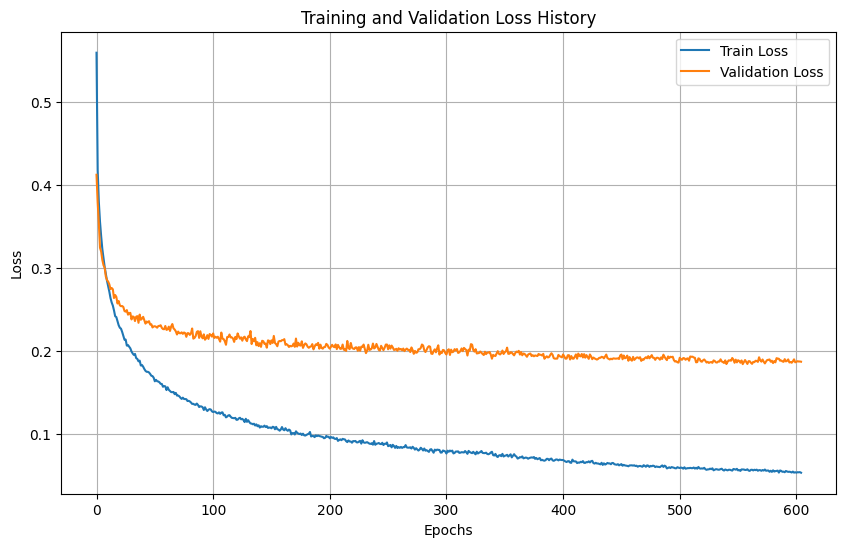

In [70]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss history
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [71]:
X_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)  # Use test data for sensitivity analysis

# Compute gradients using GradientTape
with tf.GradientTape() as tape:
    tape.watch(X_tensor)  # Track inputs
    Y_pred = model(X_tensor)  # Forward pass
    Y_last = Y_pred[:, -1]  # Select last output (Y22)

# Compute gradients (∂Y22/∂Xi for each input)
gradients = tape.gradient(Y_last, X_tensor)  # Shape: (num_samples, 26)

# Compute mean absolute sensitivity per input
sensitivity = tf.reduce_mean(tf.abs(gradients), axis=0).numpy()

In [72]:
# Define feature names
feature_names = [
    "Longitude", "Latitude", "County FIPS Code", "State FIPS Code",
    "Number of Nuclear Restrictions in State", "State Electricity Price",
    "State Net Electricity Imports", "State Nuclear Inclusive Policy",
    "Traditional Regulation In Energy Market", "5-Year Average Labor Rate",
    "Social Vulnerability Index", "Number of Intersecting Protected Lands",
    "Number of Hazardous Facilities in 5 Miles", "No Fault Lines",
    "No Landslide Area", "Peak Ground Acceleration Lower Than 0.3g",
    "Not Having A Flood in Previous 100 Years", "No Open Water Or Wetland Intersection",
    "Population Sentiment Towards Nuclear Energy", "Having A Slope Lower Than 12 Percent",
    "Population Center Distance", "Retiring Facility Distance",
    "Existing Nuclear R&D Center in 100 Miles", "Electricity Substation Distance",
    "Transportation System Distance", "50 Kgpm Streamflow Inside 20 Miles"
]

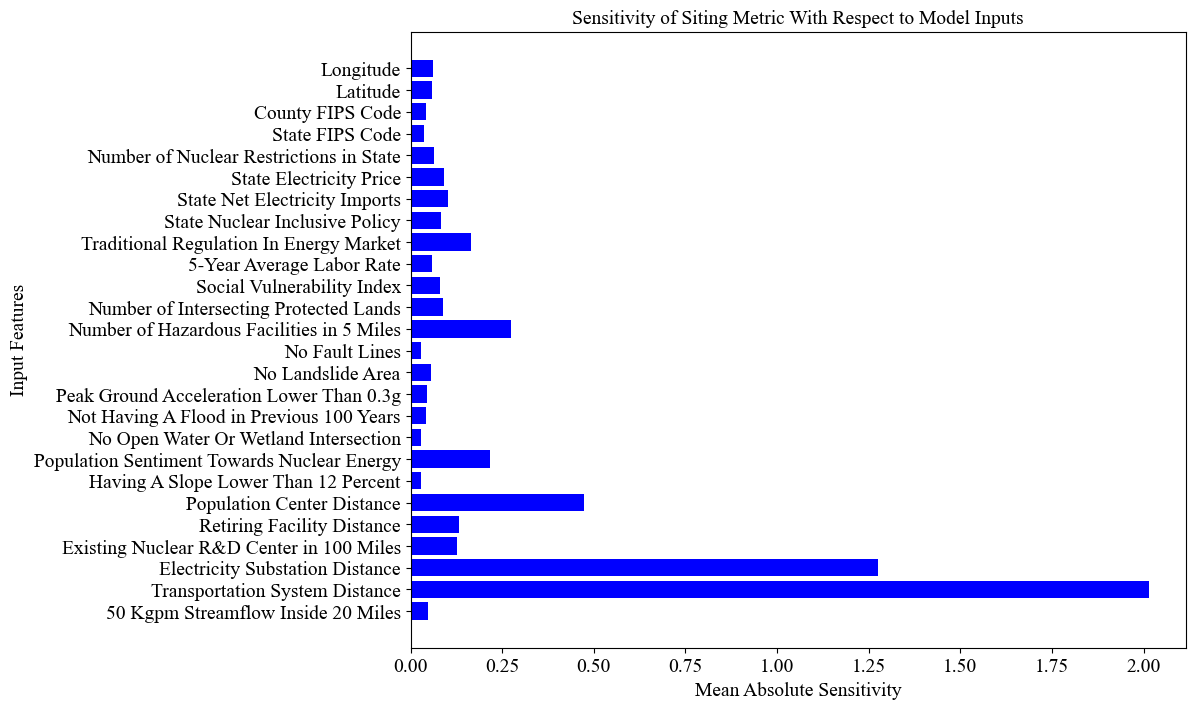

In [73]:
# Plot Sensitivity Analysis (Horizontal Bar Plot)
plt.figure(figsize=(10, 8))
plt.barh(feature_names, sensitivity, color='blue')

# Set font properties for all text elements
font_properties = {'fontname': 'Times New Roman', 'fontsize': 14}

plt.xlabel("Mean Absolute Sensitivity", **font_properties)
plt.ylabel("Input Features", **font_properties)
plt.title("Sensitivity of Siting Metric With Respect to Model Inputs", **font_properties)

# Set font for tick labels
plt.xticks(fontname='Times New Roman', fontsize=14)
plt.yticks(fontname='Times New Roman', fontsize=14)

plt.gca().invert_yaxis()  # Invert Y-axis for better readability
plt.show()

In [74]:
# This is the interpolator part of the model. This function checks if there is an entry with the exact coordinates. 
# If there isn't, then it checks for the number of locations in the same county for interpolation.
# If there is only one, then it uses the same values. If there is more, it uses the closest two to interpolate the linear objectives. Then it uses the closest ones binary values. 
# If there isn't a location in the same county, then it interpolates by using the two closest entries in the whole dataset. 

def get_location_data(df, longitude, latitude, county_fips, state_fips):
    match = df[(df.iloc[:, 1] == longitude) & (df.iloc[:, 2] == latitude)]
    # If a match is found, return the values from column index 5 onward
    if not match.empty:
        return match.iloc[0, 5:].values

    # Filter for rows with the specified state FIPS
    matched_rows = df[df.iloc[:, 4] == state_fips]
    
    # Initialize outputs with zeros for indices not yet computed
    outputs = [0] * 22

    if not matched_rows.empty:
        # Get the first match for specified columns
        matched_row = matched_rows.iloc[0]
        outputs[0] = matched_row.iloc[5]   # 5th column in df
        outputs[1] = matched_row.iloc[6]   # 6th column in df
        outputs[2] = matched_row.iloc[7]   # 7th column in df
        outputs[3] = matched_row.iloc[8]   # 8th column in df
        outputs[5] = matched_row.iloc[10]  # 10th column in df
        outputs[6] = matched_row.iloc[11]  # 11th column in df

    # Filter for rows with the same county FIPS
    county_rows = df[df.iloc[:, 3] == county_fips]  # Adjusted column for county FIPS

    # Compute the Euclidean distance for each row in county_rows
    if not county_rows.empty:
        distances = np.sqrt((county_rows.iloc[:, 1] - longitude) ** 2 + (county_rows.iloc[:, 2] - latitude) ** 2)
        
        if len(county_rows) == 1:
            # Single entry in the same county
            single_row = county_rows.iloc[0]
            outputs[4] = single_row.iloc[9]
            outputs[7] = single_row.iloc[12]
            outputs[8] = single_row.iloc[13]
            outputs[14] = single_row.iloc[19]
            outputs[16] = single_row.iloc[21]
            outputs[17] = single_row.iloc[22]
            outputs[18] = single_row.iloc[23]
            outputs[19] = single_row.iloc[24]
            outputs[20] = single_row.iloc[25]

            outputs[9] = single_row.iloc[14]
            outputs[10] = single_row.iloc[15]
            outputs[11] = single_row.iloc[16]
            outputs[12] = single_row.iloc[17]
            outputs[13] = single_row.iloc[18]
            outputs[15] = single_row.iloc[20]
            outputs[21] = single_row.iloc[26]
        
        else:
            # More than one entry in the same county, select the two closest entries
            closest_indices = distances.nsmallest(2).index
            loc1 = county_rows.loc[closest_indices[0]]
            loc2 = county_rows.loc[closest_indices[1]]
            
            # Calculate distances for interpolation weights
            dist1 = distances.loc[closest_indices[0]]
            dist2 = distances.loc[closest_indices[1]]
            weight1 = dist2 / (dist1 + dist2)
            weight2 = dist1 / (dist1 + dist2)
            
            # Perform linear interpolation for each specified output index
            outputs[4] = loc1.iloc[9] * weight1 + loc2.iloc[9] * weight2
            outputs[7] = loc1.iloc[12] * weight1 + loc2.iloc[12] * weight2
            outputs[8] = loc1.iloc[13] * weight1 + loc2.iloc[13] * weight2
            outputs[14] = loc1.iloc[19] * weight1 + loc2.iloc[19] * weight2
            outputs[16] = loc1.iloc[21] * weight1 + loc2.iloc[21] * weight2
            outputs[17] = loc1.iloc[22] * weight1 + loc2.iloc[22] * weight2
            outputs[18] = loc1.iloc[23] * weight1 + loc2.iloc[23] * weight2
            outputs[19] = loc1.iloc[24] * weight1 + loc2.iloc[24] * weight2
            outputs[20] = loc1.iloc[25] * weight1 + loc2.iloc[25] * weight2
    
            outputs[9] = loc1.iloc[14] * weight1 + loc2.iloc[14] * weight2
            outputs[10] = loc1.iloc[15] * weight1 + loc2.iloc[15] * weight2
            outputs[11] = loc1.iloc[16] * weight1 + loc2.iloc[16] * weight2
            outputs[12] = loc1.iloc[17] * weight1 + loc2.iloc[17] * weight2
            outputs[13] = loc1.iloc[18] * weight1 + loc2.iloc[18] * weight2
            outputs[15] = loc1.iloc[20] * weight1 + loc2.iloc[20] * weight2
            outputs[21] = loc1.iloc[26] * weight1 + loc2.iloc[26] * weight2

    else:
        # No entry with the same county FIPS, find the 2 closest locations across the whole dataset
        distances_all = np.sqrt((df.iloc[:, 1] - longitude) ** 2 + (df.iloc[:, 2] - latitude) ** 2)
        closest_indices_all = distances_all.nsmallest(2).index
        loc1 = df.loc[closest_indices_all[0]]
        loc2 = df.loc[closest_indices_all[1]]
        
        # Calculate distances for interpolation weights
        dist1 = distances_all[closest_indices_all[0]]
        dist2 = distances_all[closest_indices_all[1]]
        weight1 = dist2 / (dist1 + dist2)
        weight2 = dist1 / (dist1 + dist2)
        
        # Perform interpolation
        outputs[4] = loc1.iloc[9] * weight1 + loc2.iloc[9] * weight2
        outputs[7] = loc1.iloc[12] * weight1 + loc2.iloc[12] * weight2
        outputs[8] = loc1.iloc[13] * weight1 + loc2.iloc[13] * weight2
        outputs[14] = loc1.iloc[19] * weight1 + loc2.iloc[19] * weight2
        outputs[16] = loc1.iloc[21] * weight1 + loc2.iloc[21] * weight2
        outputs[17] = loc1.iloc[22] * weight1 + loc2.iloc[22] * weight2
        outputs[18] = loc1.iloc[23] * weight1 + loc2.iloc[23] * weight2
        outputs[19] = loc1.iloc[24] * weight1 + loc2.iloc[24] * weight2
        outputs[20] = loc1.iloc[25] * weight1 + loc2.iloc[25] * weight2

        outputs[9] = loc1.iloc[14] * weight1 + loc2.iloc[14] * weight2
        outputs[10] = loc1.iloc[15] * weight1 + loc2.iloc[15] * weight2
        outputs[11] = loc1.iloc[16] * weight1 + loc2.iloc[16] * weight2
        outputs[12] = loc1.iloc[17] * weight1 + loc2.iloc[17] * weight2
        outputs[13] = loc1.iloc[18] * weight1 + loc2.iloc[18] * weight2
        outputs[15] = loc1.iloc[20] * weight1 + loc2.iloc[20] * weight2
        outputs[21] = loc1.iloc[26] * weight1 + loc2.iloc[26] * weight2

    # Round specified indices before returning
    outputs[0] = int(round(outputs[0]))
    outputs[3] = int(round(outputs[3]))
    outputs[5] = int(round(outputs[5]))
    outputs[18] = int(round(outputs[18]))

    outputs[9] = int(round(outputs[9]))
    outputs[10] = int(round(outputs[10]))
    outputs[11] = int(round(outputs[11]))
    outputs[12] = int(round(outputs[12]))
    outputs[13] = int(round(outputs[13]))
    outputs[15] = int(round(outputs[15]))
    outputs[20] = int(round(outputs[20]))

    # Remove indices 9, 10, 11, 12, 13, 15, and 21
    #for index in sorted([21, 15, 13, 12, 11, 10, 9], reverse=True):
    #    del outputs[index]

    return outputs

In [75]:
x_train = X_scaler.inverse_transform(X_train)
x_test = X_scaler.inverse_transform(X_test)

In [76]:
def create_interpolated_x_test(x_test, df):
    interpolated_rows = []
    
    for row in x_test:
        # Extract the first 4 inputs
        longitude, latitude, county_fips, state_fips = row[:4]
        
        # Get interpolated outputs
        interpolated_outputs = get_location_data(df, longitude, latitude, county_fips, state_fips)
        
        # Merge the original 4 inputs with the 22 interpolated outputs
        new_row = np.concatenate((row[:4], interpolated_outputs))  # Shape: (4 + 22) = (26,)
        
        interpolated_rows.append(new_row)
    
    # Convert list to numpy array
    return np.array(interpolated_rows)

In [77]:
print(x_train.shape)
x_train_with_zeros = np.hstack((np.zeros((x_train.shape[0], 1)), x_train))
x_train_df = pd.DataFrame(x_train_with_zeros)
print(x_train_df.isna().sum().sum())  # Total number of NaN values in the DataFrame
x_test_df = pd.DataFrame(x_test)
print(x_test_df.isna().sum().sum())  # Total number of NaN values in the DataFrame

(27580, 26)
0
0


In [ ]:
# Generate x_test_interp
x_test_interp = create_interpolated_x_test(x_test, x_train_df)

X_test_interp = X_scaler.transform(x_test_interp)

# Run through the trained neural network
Y_pred_interp = model.predict(X_test_interp)
y_pred_interp = Y_scaler.inverse_transform(Y_pred_interp)

In [78]:
# Generate x_test_interp
x_train_interp = create_interpolated_x_test(x_train, x_train_df)

X_train_interp = X_scaler.transform(x_train_interp)

# Run through the trained neural network
Y_pred_interp2 = model.predict(X_train_interp)
y_pred_interp2 = Y_scaler.inverse_transform(Y_pred_interp2)

 22/216 [==>...........................] - ETA: 0s

c:\Users\Omer\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


216/216 [==============================] - 1s 5ms/step


In [79]:
# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred_interp)
mse = mean_squared_error(y_test, y_pred_interp)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_interp)

# Print results
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")

MAE: 0.005484552901995739
MSE: 0.00025798132594990954
RMSE: 0.01606179709590149
R² Score: 0.7784893258396607


In [ ]:
# Calculate evaluation metrics
mae2 = mean_absolute_error(y_train, y_pred_interp2)
mse2 = mean_squared_error(y_train, y_pred_interp2)
rmse2 = np.sqrt(mse)
r22 = r2_score(y_train, y_pred_interp2)

# Print results
print(f"MAE: {mae2}")
print(f"MSE: {mse2}")
print(f"RMSE: {rmse2}")
print(f"R² Score: {r22}")